## BPNN

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorBKP = Sequential()
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform',  input_dim = 1))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform'))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform'))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform'))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
regressorBKP.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorBKP.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  4.5299530029296875e-05
Epoch 1/200
20/20 [==============================] - 1s 23ms/step - loss: 0.1148 - val_loss: 0.0968
Epoch 2/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0645 - val_loss: 0.0413
Epoch 3/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0277 - val_loss: 0.0317
Epoch 4/200
20/20 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0224
Epoch 5/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0208 - val_loss: 0.0171
Epoch 6/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0192 - val_loss: 0.0163
Epoch 7/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0187 - val_loss: 0.0164
Epoch 8/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0188 - val_loss: 0.0168
Epoch 9/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0191 - val_loss: 0.0172
Epoch 10/200
20/20 [==============================] - 0s 

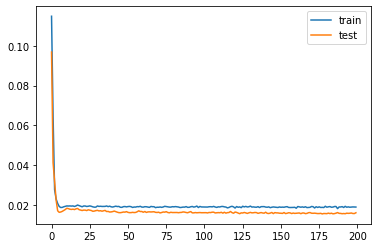

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorBKP.predict(train_X)
yhat = regressorBKP.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back= 1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

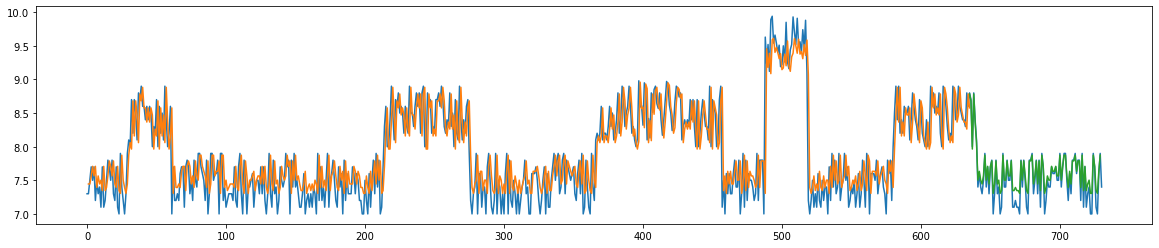

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 0.3727 RMSE
Test Score: 0.1389 MAE
Test Score: 0.0185 MAPE


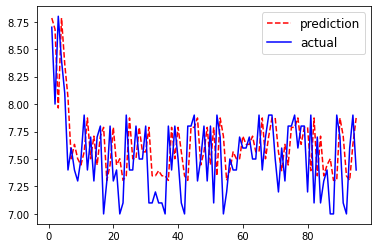

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

## SVR

In [ ]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from matplotlib import pyplot

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
clf = SVR(C=1.0, kernel='sigmoid', degree=3, gamma = 0.1, max_iter=10000)

clf.fit(train_X,train_y)

# make a prediction
predict_y = clf.predict(test_X)
yhat = predict_y.reshape(predict_y.shape[0],1)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(yhat.shape,test_X.shape)
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)
mae = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (mae))
mape = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (mape))


(95, 1) (95, 1)
Test RMSE: 0.3834
Test Score: 0.1470 MAE
Test Score: 0.0195 MAPE


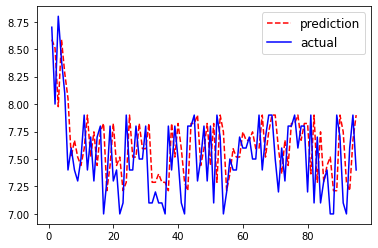

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

## SRN

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  #header 第一列为编号  index_col为取索引的参数
values = dataset.values
values = values.astype('float32')  #转化为浮点型
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))    #归一化处理
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)  #转化为监督学习  设计预测维数
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True) #reframed.drop 删除不预测的列
print(reframed.head())
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = Sequential()
model.add(SimpleRNN(units = 500, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 500, return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 500, return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 500, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1,activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = model.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


   var1(t-1)   var1(t)
1   0.102041  0.102041
2   0.102041  0.170068
3   0.170068  0.238095
4   0.238095  0.170068
5   0.170068  0.238095
Compilation Time :  4.172325134277344e-05
Epoch 1/200
20/20 [==============================] - 5s 66ms/step - loss: 0.0784 - val_loss: 0.0506
Epoch 2/200
20/20 [==============================] - 1s 33ms/step - loss: 0.0343 - val_loss: 0.0140
Epoch 3/200
20/20 [==============================] - 1s 33ms/step - loss: 0.0204 - val_loss: 0.0203
Epoch 4/200
20/20 [==============================] - 1s 32ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 5/200
20/20 [==============================] - 1s 33ms/step - loss: 0.0205 - val_loss: 0.0184
Epoch 6/200
20/20 [==============================] - 1s 33ms/step - loss: 0.0199 - val_loss: 0.0165
Epoch 7/200
20/20 [==============================] - 1s 31ms/step - loss: 0.0194 - val_loss: 0.0156
Epoch 8/200
20/20 [==============================] - 1s 32ms/step - loss: 0.0190 - val_loss: 0.0160
Epoch 9/200
20/20 [=

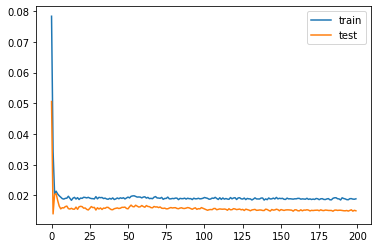

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=model.predict(train_X)
yhat = model.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back= 1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

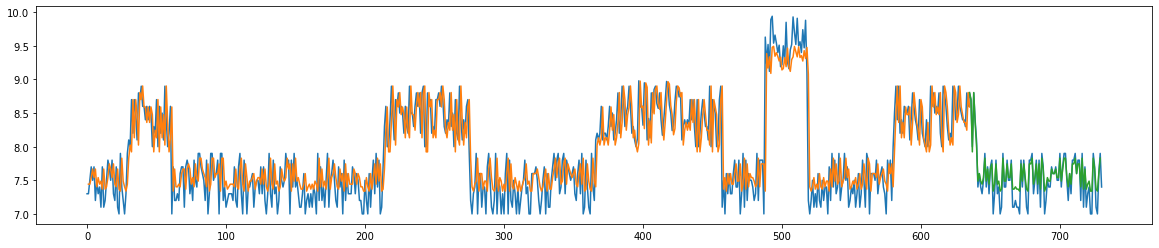

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 0.3600 RMSE
Test Score: 0.1296 MAE
Test Score: 0.0172 MAPE


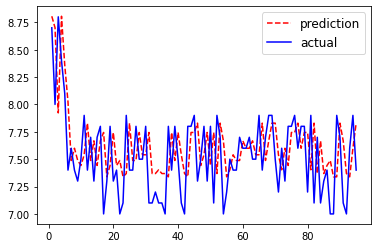

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#LSTM

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  #header 第一列为编号  index_col为取索引的参数
values = dataset.values
values = values.astype('float32')  #转化为浮点型
scaler = MinMaxScaler(feature_range=(0, 1))    #归一化处理
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)  #转化为监督学习  设计预测维数
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressor = Sequential()
regressor.add(LSTM(units = 500, return_sequences = True, input_shape = (train_X.shape[1],train_X.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 500, return_sequences = True ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 500, return_sequences = True ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 500, return_sequences=False ))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1,activation = 'sigmoid'))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressor.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  4.38690185546875e-05
Epoch 1/200
20/20 [==============================] - 13s 200ms/step - loss: 0.0807 - val_loss: 0.0670
Epoch 2/200
20/20 [==============================] - 2s 98ms/step - loss: 0.0598 - val_loss: 0.0343
Epoch 3/200
20/20 [==============================] - 2s 100ms/step - loss: 0.0369 - val_loss: 0.0203
Epoch 4/200
20/20 [==============================] - 2s 97ms/step - loss: 0.0209 - val_loss: 0.0162
Epoch 5/200
20/20 [==============================] - 2s 96ms/step - loss: 0.0185 - val_loss: 0.0189
Epoch 6/200
20/20 [==============================] - 2s 98ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 7/200
20/20 [==============================] - 2s 97ms/step - loss: 0.0193 - val_loss: 0.0181
Epoch 8/200
20/20 [==============================] - 2s 97ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 9/200
20/20 [==============================] - 2s 99ms/step - loss: 0.0191 - val_loss: 0.0171
Epoch 10/200
20/20 [==============================] - 2s

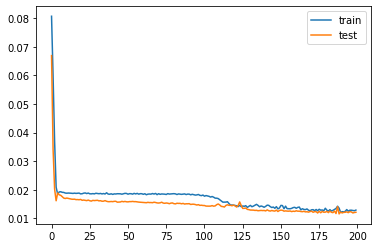

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressor.predict(train_X)
yhat = regressor.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

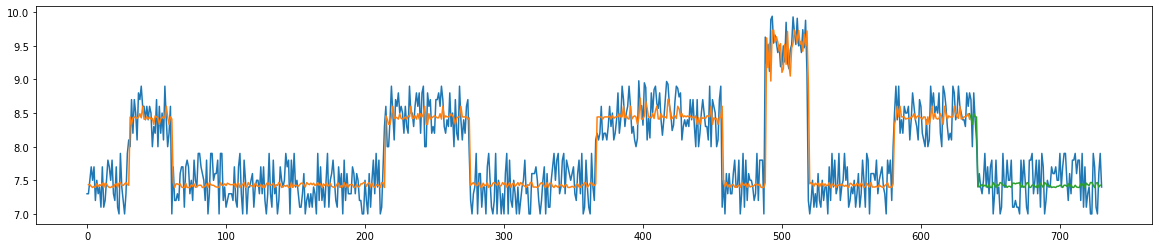

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 0.3238 RMSE
Test Score: 0.1048 MAE
Test Score: 0.0139 MAPE


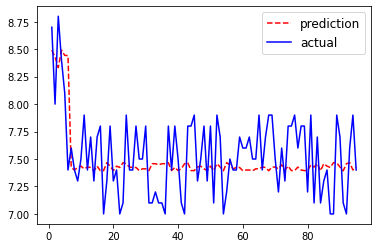

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#GRU

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  #header 第一列为编号  index_col为取索引的参数
values = dataset.values
values = values.astype('float32')  #转化为浮点型
scaler = MinMaxScaler(feature_range=(0, 1))    #归一化处理
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)  #转化为监督学习  设计预测维数
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorGRU = Sequential()
regressorGRU.add(GRU(units=500, return_sequences=True, input_shape=(train_X.shape[1],train_X.shape[2])))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=500, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=500, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=500,return_sequences=False))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1,activation = 'sigmoid'))
regressorGRU.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorGRU.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  4.458427429199219e-05
Epoch 1/200
20/20 [==============================] - 13s 176ms/step - loss: 0.0761 - val_loss: 0.0613
Epoch 2/200
20/20 [==============================] - 2s 80ms/step - loss: 0.0500 - val_loss: 0.0236
Epoch 3/200
20/20 [==============================] - 2s 79ms/step - loss: 0.0229 - val_loss: 0.0176
Epoch 4/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0224 - val_loss: 0.0244
Epoch 5/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0217 - val_loss: 0.0234
Epoch 6/200
20/20 [==============================] - 2s 80ms/step - loss: 0.0211 - val_loss: 0.0206
Epoch 7/200
20/20 [==============================] - 2s 81ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 8/200
20/20 [==============================] - 2s 80ms/step - loss: 0.0196 - val_loss: 0.0181
Epoch 9/200
20/20 [==============================] - 2s 79ms/step - loss: 0.0193 - val_loss: 0.0175
Epoch 10/200
20/20 [==============================] - 2s

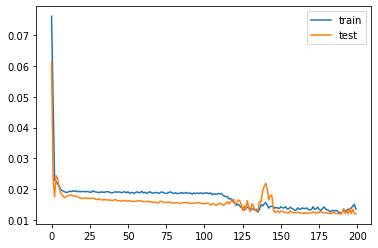

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorGRU.predict(train_X)
yhat = regressorGRU.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

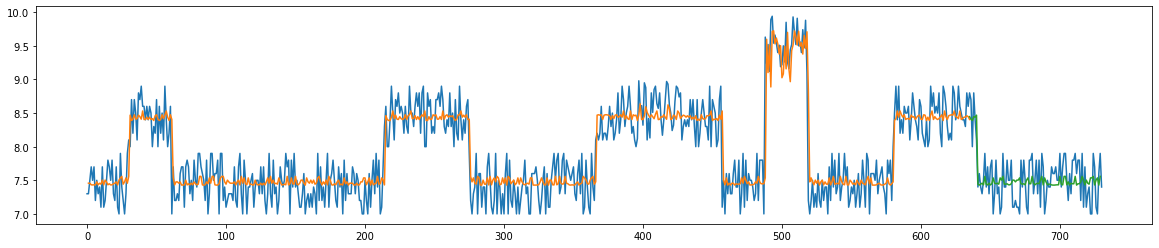

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 0.3221 RMSE
Test Score: 0.1037 MAE
Test Score: 0.0138 MAPE


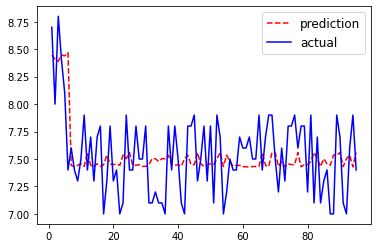

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#BiLSTM

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorBilstm = Sequential()
regressorBilstm.add(Bidirectional(LSTM(units = 500, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2]))))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Bidirectional(LSTM(units = 500, return_sequences = True)))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Bidirectional(LSTM(units = 500, return_sequences = True)))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Bidirectional(LSTM(units = 500 ,return_sequences=False)))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Dense(units = 1,activation = 'sigmoid'))
regressorBilstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorBilstm.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  4.029273986816406e-05
Epoch 1/200
20/20 [==============================] - 32s 499ms/step - loss: 0.0789 - val_loss: 0.0524
Epoch 2/200
20/20 [==============================] - 5s 257ms/step - loss: 0.0393 - val_loss: 0.0308
Epoch 3/200
20/20 [==============================] - 5s 256ms/step - loss: 0.0227 - val_loss: 0.0237
Epoch 4/200
20/20 [==============================] - 5s 263ms/step - loss: 0.0207 - val_loss: 0.0175
Epoch 5/200
20/20 [==============================] - 5s 259ms/step - loss: 0.0191 - val_loss: 0.0165
Epoch 6/200
20/20 [==============================] - 5s 258ms/step - loss: 0.0189 - val_loss: 0.0168
Epoch 7/200
20/20 [==============================] - 5s 265ms/step - loss: 0.0189 - val_loss: 0.0171
Epoch 8/200
20/20 [==============================] - 5s 256ms/step - loss: 0.0188 - val_loss: 0.0174
Epoch 9/200
20/20 [==============================] - 5s 261ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 10/200
20/20 [============================

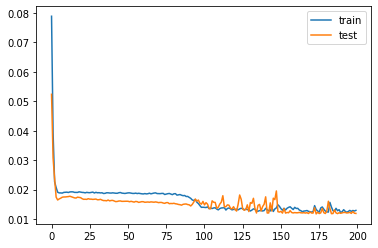

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorBilstm.predict(train_X)
yhat = regressorBilstm.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

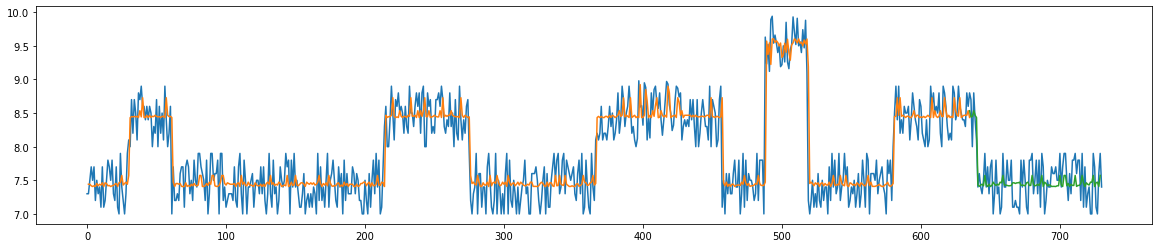

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 0.3209 RMSE
Test Score: 0.1030 MAE
Test Score: 0.0137 MAPE


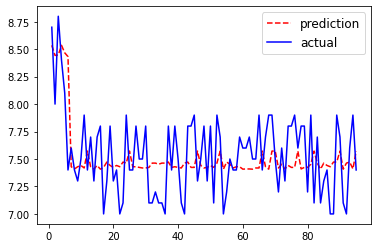

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

## Improved RNN

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[2])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorIMRNN = Sequential()
regressorIMRNN.add((SimpleRNN(units = 500, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2]))))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((SimpleRNN(units = 500, return_sequences = True)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((LSTM(units = 500, return_sequences = True )))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((LSTM(units = 500, return_sequences = True)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((GRU(units = 500, return_sequences = True )))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((GRU(units = 500, return_sequences = True)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((SimpleRNN(units = 500, return_sequences = False)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add(Dense(units = 1,activation = 'sigmoid'))
regressorIMRNN.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorIMRNN.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  4.649162292480469e-05
Epoch 1/200
20/20 [==============================] - 15s 238ms/step - loss: 0.0719 - val_loss: 0.0565
Epoch 2/200
20/20 [==============================] - 2s 115ms/step - loss: 0.0552 - val_loss: 0.0256
Epoch 3/200
20/20 [==============================] - 2s 114ms/step - loss: 0.0468 - val_loss: 0.0319
Epoch 4/200
20/20 [==============================] - 2s 115ms/step - loss: 0.0366 - val_loss: 0.0154
Epoch 5/200
20/20 [==============================] - 2s 117ms/step - loss: 0.0217 - val_loss: 0.0195
Epoch 6/200
20/20 [==============================] - 2s 118ms/step - loss: 0.0214 - val_loss: 0.0171
Epoch 7/200
20/20 [==============================] - 2s 115ms/step - loss: 0.0200 - val_loss: 0.0159
Epoch 8/200
20/20 [==============================] - 2s 115ms/step - loss: 0.0194 - val_loss: 0.0161
Epoch 9/200
20/20 [==============================] - 2s 120ms/step - loss: 0.0199 - val_loss: 0.0159
Epoch 10/200
20/20 [============================

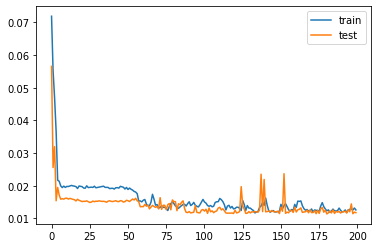

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorIMRNN.predict(train_X)
yhat = regressorIMRNN.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

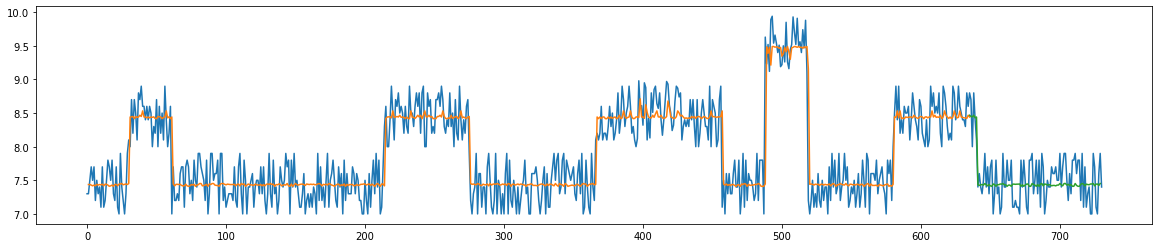

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 0.3189 RMSE
Test Score: 0.1017 MAE
Test Score: 0.0135 MAPE


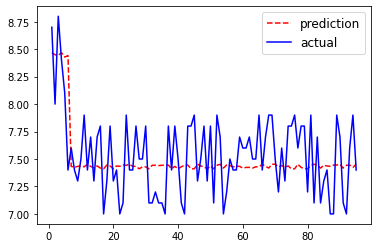

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()